# GROUP PROJECT
## Student1:LIUJINGDI ID:20090712G
## Student2:HUANGZHEMING ID:20085189G

## 0.Function Introduction  
- **plot_distribution(data,) ::**
    - plot the feature distribution to find out some valuable info
- **splitting_NN(y_test, y_pred) ::** 
    - split the sentences to the words, can only pick up the noun    
- **getkeyword(sentence) ::**  
    - use TFIDF method to get the keyword of the text feature  
- **model_evaluation(y_test, y_pred) ::**  
    - convient to show the model performance on our validation data.  
- **model_fit_predict(model, x_train, y_train, x_test, y_test, params=None) ::**  
    - One training process of a specific model and can print out the model report

In [7]:
# ensure the data format is pd.series (means DataFrame['col1'])
# show the distribution in hist picture
def plot_distribution(data,):
    feature = data.name
    figure, ax = plt.subplots(figsize=(5,5))
    ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
    ax.set_xlabel("Value")
    ax.set_ylabel("Number of Records")
    ax.hist(data,color='darkseagreen', bins = 50)

In [110]:
# show the parameter and the scores curve
def plot_curve(x, y, title=None, xlabel='default', ylabel='default', label1='default', xtick_norm=True):
    fig, ax = plt.subplots(figsize=(10,7))
    
    ax.set_title(title, fontsize=16)
    ax.set_xlabel(xlabel, fontsize=16)
    ax.set_ylabel(ylabel, fontsize=16)

    # 
    ax.minorticks_on() 
    ax.grid()
    if xtick_norm:
        # 
        x_list = list(range(len(x)))
        ax.set_xlim(0,len(x))
        start, end = ax.get_xlim() 
        
        # 
        plt.xticks(np.arange(start, end, 1), x)
    

    ax.plot(x_list, y, label=label1, color='darkseagreen')
    
    plt.legend()

In [9]:
# function to handling the text feature.
import re
import nltk

def removePunctuation(text):
    # punctuation customize the re query regular.
    punctuation = '!,;:.?"\'(){}\[\]/#$%^&*\-+_123456780`'
    text = re.sub(r'[{}]+'.format(punctuation),' ',text)
    return text.strip().lower()

# custom splitting function
# split by any ' ' '\t' '\n' 
def split_word(word):
    word_clean = removePunctuation(word)
    return word_clean.split()

# with the lib nltk, can only pick up the noun
def splitting_NN(data):
    sentence = []
    for i in data: 
        #wordtokenized = nltk.word_tokenize(i)
        wordtokenized = split_word(i)
        wordtagged = nltk.pos_tag(wordtokenized)
        sub_sentence = []
        for i in wordtagged:
            if i[1] in ['FW', 'JJ', 'NN', 'NNS', 'NNP', 'NNPS']:
                sub_sentence.append(i[0])    
        sentence.append(sub_sentence)
    return sentence

In [11]:
# keyword extracting fcuntion
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
'''
sentence :: splitted sentences such as [[a, b],[c, a]]
return :: data in list format
'''
def getkeyword(sentence):
    # dictionary :: turn the sentence into a dictionary with the unique ID
    dictionary = Dictionary(sentence)

    # new_corpus :: get the words` frequence in its sentence
    # dictionary.doc2bow(i) :: make sure i is a sentences_list, will renturn the each words frequence in (id, frequence)
    new_corpus = [dictionary.doc2bow(i) for i in sentence]
    
    # training a TF-IDF model
    tfidf = TfidfModel(new_corpus)
    
    # corpus_tfidf :: get every words tfidf values and return in (id, TFIDF)
    corpus_tfidf = tfidf[new_corpus]
    
    # get the words in each sentence with the maximum tfidf as the keyword
    keywords = []
    for line in corpus_tfidf:
        c = 0
        v = 0
        for i in line:
            if i[1] > c:
                c = i[1]
                v = i[0]
        # and fetch the str word
        keywords.append(dictionary.get(v))
    return keywords

In [5]:
from sklearn import metrics
# return :: dict of evaluation
def model_evaluation(y_test, y_pred):
    evaluation = {}
    # variance_score
    evaluation['Variance_Score'] = metrics.explained_variance_score(y_test, y_pred)
    # MSE the project main target
    evaluation['MSE'] = metrics.mean_squared_error(y_test, y_pred)
    # MAE reflect the actual error
    evaluation['MAE'] = metrics.mean_absolute_error(y_test, y_pred)
    # R2_scores can describe how the x fit the y
    evaluation['R2_scores'] = metrics.r2_score(y_test, y_pred)
    return evaluation

# One training process of a specific model
# and print out the model report
def model_fit_predict(model, x_train, y_train, x_test, y_test, params=None):
    results = {}
    
    start = time()
    model = model.fit(x_train, y_train)
    end = time()
    results['train_time'] = end - start
    
    start = time() # Get start time
    y_pred = model.predict(x_test)
    end = time() # Get end time
    results['pred_time'] = end - start
    
    results['evaluation'] = model_evaluation(y_test, y_pred)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    plt.plot(np.arange(len(y_test)), y_test,'go-',label='true value')
    plt.plot(np.arange(len(y_test)), y_pred,'ro-',label='predict value')
    plt.legend()
    
    return results, model 

## 1. Data Preprocessing  
1. **Data Domain Analysis**  
2. **Text Feature**
    - On-hot encode  
    - Splitting words    
    - TF-IDF   
    - Mapreduce  
3. **Numerical Feature**
    - Log 
    - Minmax
    - standard

### 1.1 Data Domain Analysis

In [12]:
# import some libs we want to use
# initially based on MLP model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from gensim.models import Word2Vec                   # word2vec model 
from sklearn import model_selection                  # can split the training set into trainning data and validation data
from sklearn import metrics                          # evaluation 
from sklearn.preprocessing import MinMaxScaler       # normalization method
from sklearn.preprocessing import StandardScaler     # normalization method
from IPython.display import display                  
from time import time
from pprint import pprint
import warnings
warnings.filterwarnings('ignore')

In [198]:
# import the data set as pd format
data_path      = 'Train_data.csv'
data_verification_path = 'Test_data.csv'
data           = pd.read_csv(data_path, encoding='utf-8')
data_verification_raw      = pd.read_csv(data_verification_path, encoding='utf-8')
data_verification = data_verification_raw.copy()
#data.columns.apply(lambda x:strip(x))

# make sure the columns clear.
data.columns = [i.strip() for i in data.columns]
data_verification.columns = [i.strip() for i in data_verification.columns]

# show the data details
display(data.head(),data.shape)

# check out the null values
data.info()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,8253,Little Town on the Prairie (Little House #7),Laura Ingalls Wilder/Garth Williams,4.19,0060885432,9780060885434,eng,374,71853,646,20070101,HarperTrophy
1,11101,First Comes Love (Hot Water California #1),Christie Ridgway,3.81,0380818957,9780380818952,en-US,384,1051,47,20020101,Avon Books
2,28193,When Santa Fell to Earth,Cornelia Funke/Paul Howard/Oliver G. Latsch,3.76,043978204X,9780439782043,eng,167,1840,245,20060110,Chicken House / Scholastic
3,25047,The Case of the Stinky Science Project (Jigsaw...,James Preller/John Speirs/James Preller,3.83,0439114284,9780439114288,en-US,80,162,11,20010103,Scholastic Paperbacks
4,17800,Dance Dance Dance,Haruki Murakami,4.04,0099448769,9780099448761,eng,393,50169,2117,20020702,Vintage


(10000, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   bookID              10000 non-null  int64  
 1   title               10000 non-null  object 
 2   authors             10000 non-null  object 
 3   average_rating      10000 non-null  float64
 4   isbn                10000 non-null  object 
 5   isbn13              10000 non-null  int64  
 6   language_code       10000 non-null  object 
 7   num_pages           10000 non-null  int64  
 8   ratings_count       10000 non-null  int64  
 9   text_reviews_count  10000 non-null  int64  
 10  publication_date    10000 non-null  int64  
 11  publisher           10000 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 937.6+ KB


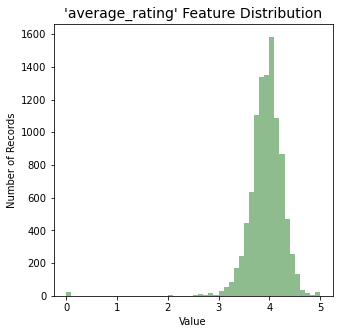

In [199]:
# check the distribution of feature.
plot_distribution(data.average_rating, )

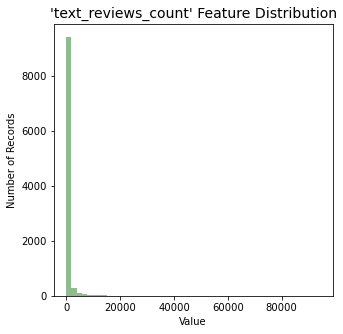

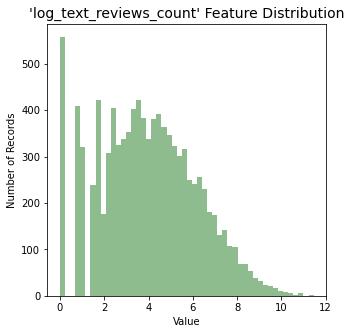

In [200]:
# try use log method to fit the distribution to normal distribution
plot_distribution(data.text_reviews_count, )
dealt_data = data.text_reviews_count.apply(lambda x:np.log(x+1))
dealt_data.name = 'log_text_reviews_count'
plot_distribution(dealt_data, )

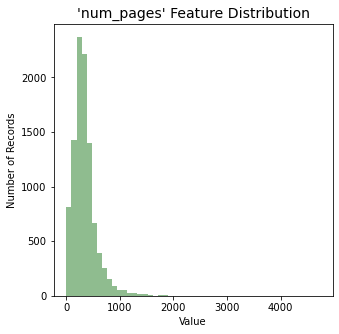

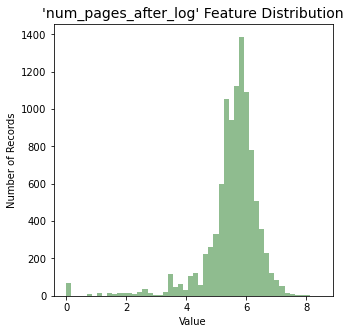

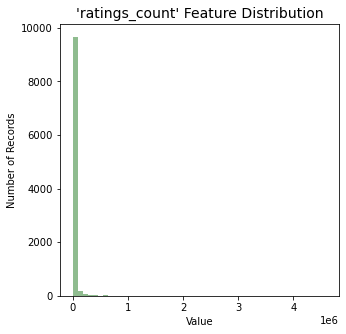

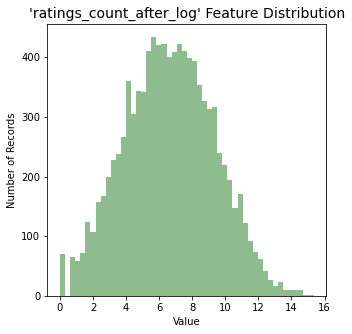

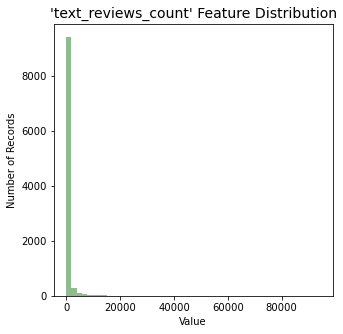

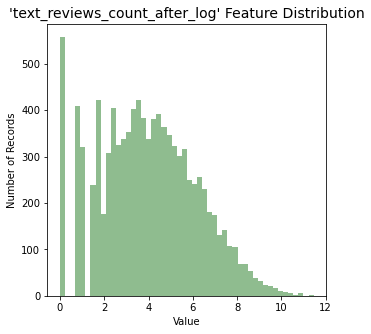

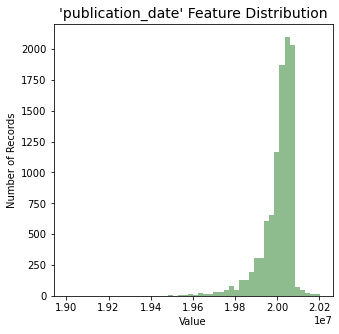

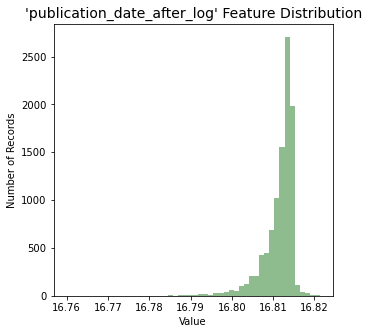

In [201]:
# try another continuous feature
for i in ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date']:
    try:
        plot_distribution(data[i], )
        med_data = data[i].apply(lambda x: np.log(x+1))
        med_data.name = i + '_after_log'
        plot_distribution(med_data, )
    except BaseException as e:
        print(e)

### 1.2 Text Feature  
1. Splitting words  
    - define a custom splitting function in which we can appoint the split_str we want  
    - with the lib nltk to extract only noun word 
2. Wrod2Vec 
3. TF-IDF  
4. One hot encoding  

In [202]:
# splitting words

title_data = pd.concat([data.title, data_verification.title], ignore_index=1)
authors_data = pd.concat([data.authors, data_verification.authors], ignore_index=1)
publisher_data = pd.concat([data.publisher, data_verification.publisher], ignore_index=1)

# ver1 ignore the part of speech.
# there may be some null list after spliting
# title_sentence = []
# for i in title_data: 
#     title_sentence.append(split_word(i))

# authors_sentence = []
# for i in authors_data:
#     authors_sentence.append(split_word(i))

# publisher_sentence = []
# for i in publisher_data:
#     publisher_sentence.append(split_word(i))

# ver2 splitting and filter the non-noun words
title_sentence = splitting_NN(title_data)
authors_sentence = splitting_NN(authors_data)
publisher_sentence = splitting_NN(publisher_data)

sentence = title_sentence + authors_sentence + publisher_sentence

num = 0
for i in sentence:
    for j in i:
        num = num+ 1

print('Splitting ends, Checkout the results:\n', 'Original Sentence: \'Little Town on the Prairie  (Little House  #7)\'',  '\n splitting:', sentence[:1])

print('Total words we got from our data:', len(sentence), num)

Splitting ends, Checkout the results:
 Original Sentence: 'Little Town on the Prairie  (Little House  #7)' 
 splitting: [['little', 'town', 'prairie', 'little', 'house']]
Total words we got from our data: 33000 98738


In [203]:
# train the Word2Vec modeol
# min_count = 1 because we only use 98738 words here (small dataset), so set that one word can be count.
w2v_model = Word2Vec(sentences=sentence, size=50, min_count=1)
w2v_model.save("bdc_word2vec_ver5_nltk.model")
w2v_model = Word2Vec.load('bdc_word2vec_ver5_nltk.model')

In [204]:
print("After w2v model established, we can show the vector for 'computer':\n", w2v_model.wv[['computer']])

After w2v model established, we can show the vector for 'computer':
 [[ 0.01052102  0.0021116   0.02157894 -0.00874368 -0.01334198  0.0120686
   0.01697796 -0.02641305  0.00048327 -0.00877458  0.06589409 -0.0206665
  -0.03774444  0.00581922 -0.02520342 -0.02688     0.022674    0.02169557
  -0.04960738  0.035686   -0.00082449 -0.0250108   0.00852789 -0.00683571
   0.00998836 -0.02290089 -0.02483361 -0.00133021 -0.02144158 -0.00489062
   0.0008855   0.0290772  -0.0315044   0.04111263 -0.01590818  0.01079202
  -0.00529888 -0.04587885 -0.01003391  0.01071385  0.00385276 -0.03034543
   0.05210005  0.02589159 -0.01186039 -0.06561941 -0.00076329 -0.01124689
   0.00521775 -0.01077506]]


In [205]:
# Keywords extraction
# Based on TF-IDF
# title！！！
keywords = getkeyword(title_sentence)
keywords_vec = w2v_model.wv[keywords]
# turn the keyword from str to vec
title_data = keywords_vec[:len(data.title)]
title_data_verification = keywords_vec[-len(data_verification.title):]

In [206]:
# authors！！！
keywords = getkeyword(authors_sentence)
keywords_vec = w2v_model.wv[keywords]
authors_data = keywords_vec[:len(data.authors)]
authors_data_verification = keywords_vec[-len(data_verification.authors):]

In [207]:
# publisher！！！
keywords = getkeyword(publisher_sentence)
keywords_vec = w2v_model.wv[keywords]
publisher_data = keywords_vec[:len(data.publisher)]
publisher_data_verification = keywords_vec[-len(data_verification.publisher):]

In [208]:
# check the performance of the keyword extraction
for i in range(10):
    print(data.publisher[i],' |****keyword:', keywords[i])

HarperTrophy  |****keyword: harpertrophy
Avon Books  |****keyword: avon
Chicken House / Scholastic  |****keyword: chicken
Scholastic Paperbacks  |****keyword: scholastic
Vintage  |****keyword: vintage
Houghton Mifflin Harcourt  |****keyword: harcourt
Association for Supervision & Curriculum Development  |****keyword: curriculum
HarperTorch  |****keyword: harpertorch
Random House  |****keyword: random
Viking Adult  |****keyword: adult


In [209]:
# continue to handdle the dataset
new_data = data.drop(columns=['title', 'publisher', 'authors', 'isbn13', 'isbn', 'bookID'])
title_vec = pd.DataFrame(title_data, columns=[('title_vec_'+str(i)) for i in range(len(title_data[0]))])
authors_vec = pd.DataFrame(authors_data, columns=[('authors_vec_'+str(i)) for i in range(len(authors_data[0]))])
publisher_vec = pd.DataFrame(publisher_data, columns=[('publisher_vec_'+str(i)) for i in range(len(publisher_data[0]))])

In [210]:
new_data = pd.concat([new_data, authors_vec, publisher_vec], axis=1)
display(new_data)

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,...,publisher_vec_40,publisher_vec_41,publisher_vec_42,publisher_vec_43,publisher_vec_44,publisher_vec_45,publisher_vec_46,publisher_vec_47,publisher_vec_48,publisher_vec_49
0,4.19,eng,374,71853,646,20070101,0.012383,-0.000615,0.014547,-0.020249,...,0.001992,-0.005712,0.005086,0.008080,0.009388,0.009661,-0.006235,-0.003460,0.008236,-0.006501
1,3.81,en-US,384,1051,47,20020101,-0.004777,0.005657,0.003100,-0.000681,...,0.000520,0.013866,-0.060980,-0.022759,0.012676,0.075522,-0.018636,0.022762,-0.011437,0.004474
2,3.76,eng,167,1840,245,20060110,-0.008891,0.003968,-0.008965,0.002783,...,-0.000037,-0.004230,0.014789,0.012188,0.001017,-0.017613,0.006671,-0.008660,-0.007416,-0.008700
3,3.83,en-US,80,162,11,20010103,-0.003707,0.007978,0.008904,0.009631,...,0.013499,-0.094094,0.185421,0.042572,-0.001479,-0.179605,0.032184,-0.064003,0.010076,0.051001
4,4.04,eng,393,50169,2117,20020702,0.009290,-0.009491,0.034889,0.000860,...,-0.011919,-0.024864,0.064964,0.012248,-0.011017,-0.073085,0.010099,-0.004717,-0.000320,-0.004732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,eng,768,66,7,19912412,-0.001503,-0.005850,0.005244,0.006564,...,-0.002485,-0.019801,0.058093,0.035290,-0.013855,-0.054805,0.017922,-0.005387,0.002801,-0.004462
9996,3.46,eng,161,6994,431,20002607,-0.001932,0.008124,0.000188,0.008901,...,-0.016569,-0.066778,0.096856,0.093593,-0.031721,-0.148599,0.008495,-0.049312,0.009550,0.008248
9997,4.08,eng,425,81,10,19970508,0.003226,0.006174,0.010874,0.005650,...,-0.070432,-0.086170,0.429437,0.391332,0.072249,-0.473941,-0.034453,-0.175643,0.158589,0.139813
9998,3.90,spa,432,2,0,20060711,0.011512,0.001221,0.015054,-0.006915,...,0.001783,-0.001582,0.006642,-0.008941,-0.001837,-0.005981,-0.004872,-0.008657,-0.002686,-0.003959


In [211]:
# One-Hot encode
from sklearn.preprocessing import LabelEncoder

# 先对language_encode进行预处理，
# merge the ouliers categories feature values
# use re to implement the SQLwhere-like filter

# before
display(new_data['language_code'].value_counts())

# haddling
get_bool = new_data['language_code'].str.contains(r'^(?:(?!eng|en-US|en-GB|spa|fre|ger|jpn).)*$')
new_data['language_code'][get_bool] = 'codex'
display(new_data)

# after
display(new_data['language_code'].value_counts())

eng      8001
en-US    1285
en-GB     189
spa       187
fre       130
ger        85
jpn        44
mul        19
zho        12
grc        10
por         9
en-CA       6
ita         4
enm         3
lat         3
swe         2
rus         2
nor         1
gla         1
nl          1
tur         1
msa         1
wel         1
srp         1
glg         1
ara         1
Name: language_code, dtype: int64

,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,...,publisher_vec_40,publisher_vec_41,publisher_vec_42,publisher_vec_43,publisher_vec_44,publisher_vec_45,publisher_vec_46,publisher_vec_47,publisher_vec_48,publisher_vec_49
0,4.19,eng,374,71853,646,20070101,0.012383,-0.000615,0.014547,-0.020249,...,0.001992,-0.005712,0.005086,0.008080,0.009388,0.009661,-0.006235,-0.003460,0.008236,-0.006501
1,3.81,en-US,384,1051,47,20020101,-0.004777,0.005657,0.003100,-0.000681,...,0.000520,0.013866,-0.060980,-0.022759,0.012676,0.075522,-0.018636,0.022762,-0.011437,0.004474
2,3.76,eng,167,1840,245,20060110,-0.008891,0.003968,-0.008965,0.002783,...,-0.000037,-0.004230,0.014789,0.012188,0.001017,-0.017613,0.006671,-0.008660,-0.007416,-0.008700
3,3.83,en-US,80,162,11,20010103,-0.003707,0.007978,0.008904,0.009631,...,0.013499,-0.094094,0.185421,0.042572,-0.001479,-0.179605,0.032184,-0.064003,0.010076,0.051001
4,4.04,eng,393,50169,2117,20020702,0.009290,-0.009491,0.034889,0.000860,...,-0.011919,-0.024864,0.064964,0.012248,-0.011017,-0.073085,0.010099,-0.004717,-0.000320,-0.004732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,eng,768,66,7,19912412,-0.001503,-0.005850,0.005244,0.006564,...,-0.002485,-0.019801,0.058093,0.035290,-0.013855,-0.054805,0.017922,-0.005387,0.002801,-0.004462
9996,3.46,eng,161,6994,431,20002607,-0.001932,0.008124,0.000188,0.008901,...,-0.016569,-0.066778,0.096856,0.093593,-0.031721,-0.148599,0.008495,-0.049312,0.009550,0.008248
9997,4.08,eng,425,81,10,19970508,0.003226,0.006174,0.010874,0.005650,...,-0.070432,-0.086170,0.429437,0.391332,0.072249,-0.473941,-0.034453,-0.175643,0.158589,0.139813
9998,3.90,spa,432,2,0,20060711,0.011512,0.001221,0.015054,-0.006915,...,0.001783,-0.001582,0.006642,-0.008941,-0.001837,-0.005981,-0.004872,-0.008657,-0.002686,-0.003959


eng      8001
en-US    1285
en-GB     189
spa       187
fre       130
ger        85
codex      79
jpn        44
Name: language_code, dtype: int64

In [212]:
# pd.get_dummies(df)
# 
data_input = pd.get_dummies(new_data)
display(data_input.iloc[:, -8:])

,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,0,0,0,1,0,0,0,0
1,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0
3,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...
9995,0,0,0,1,0,0,0,0
9996,0,0,0,1,0,0,0,0
9997,0,0,0,1,0,0,0,0
9998,0,0,0,0,0,0,0,1


### 1.3. **Numerical Feature**
- Log 
- Minmax
- standard

In [213]:
# log the numerical feature to change the huge range as well as the distribution to fit the normal distribution
feature_log = ['num_pages', 'ratings_count', 'text_reviews_count']
data_input[feature_log] = data_input[feature_log].apply(lambda x:np.log(x+1))

In [214]:
# Try different normalization method here.
# StandardScaler : outlies is not so important.
# MinMaxScaler : very easily effected by the outliers.

g = StandardScaler().fit_transform(data_input)
standarall = pd.DataFrame(g , columns=data_input.columns)
standarall['average_rating'] = data_input['average_rating']

g = MinMaxScaler().fit_transform(data_input)
minmaxall = pd.DataFrame(g , columns=data_input.columns)
minmaxall['average_rating'] = data_input['average_rating']

In [215]:
# "finally we decide to use standarscaler because of its better performance in our dataset"
# "and we use the normalization in only the previous continuous feature"
feature_selection = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date'] 
data_final = data_input
data_final[feature_selection] = standarall[feature_selection]
display(data_final)

,average_rating,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,...,publisher_vec_48,publisher_vec_49,language_code_codex,language_code_en-GB,language_code_en-US,language_code_eng,language_code_fre,language_code_ger,language_code_jpn,language_code_spa
0,4.19,0.406167,1.689831,1.146302,0.820252,0.012383,-0.000615,0.014547,-0.020249,-0.008525,...,0.008236,-0.006501,0,0,0,1,0,0,0,0
1,3.81,0.434354,0.128688,-0.028091,0.208883,-0.004777,0.005657,0.003100,-0.000681,0.003496,...,-0.011437,0.004474,0,0,1,0,0,0,0,0
2,3.76,-0.453822,0.335518,0.709703,0.698089,-0.008891,0.003968,-0.008965,0.002783,0.001615,...,-0.007416,-0.008700,0,0,0,1,0,0,0,0
3,3.83,-1.235148,-0.560493,-0.653990,0.086633,-0.003707,0.007978,0.008904,0.009631,0.004561,...,0.010076,0.051001,0,0,1,0,0,0,0,0
4,4.04,0.459102,1.557065,1.681716,0.216231,0.009290,-0.009491,0.034889,0.000860,-0.006601,...,-0.000320,-0.004732,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,4.10,1.175337,-0.889083,-0.837054,-1.107873,-0.001503,-0.005850,0.005244,0.006564,-0.002880,...,0.002801,-0.004462,0,0,0,1,0,0,0,0
9996,3.46,-0.492773,0.828884,0.963935,-0.005023,-0.001932,0.008124,0.000188,0.008901,0.005053,...,0.009550,0.008248,0,0,0,1,0,0,0,0
9997,4.08,0.542737,-0.814415,-0.693275,-0.397510,0.003226,0.006174,0.010874,0.005650,0.004119,...,0.158589,0.139813,0,0,0,1,0,0,0,0
9998,3.90,0.560193,-2.037071,-1.775903,0.705437,0.011512,0.001221,0.015054,-0.006915,-0.003005,...,-0.002686,-0.003959,0,0,0,0,0,0,0,1


In [216]:
# filter the rating outlier
data_final = data_final[data_final['average_rating'] >= 2]

'isbn13'
'title_vec_0'


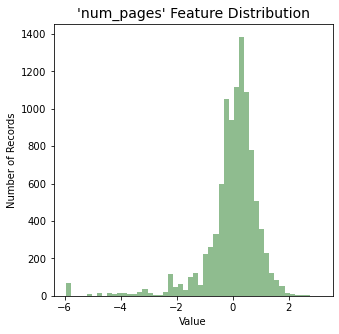

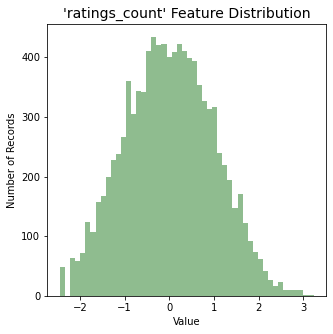

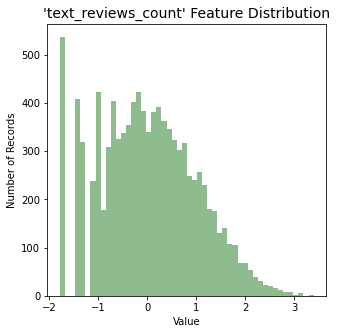

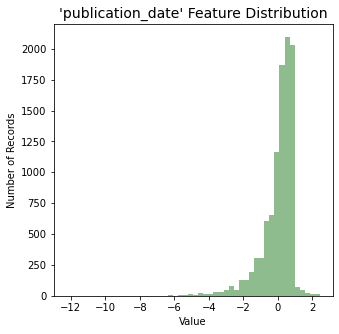

In [217]:
# show how the log influence our feature
for i in ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'isbn13', 'title_vec_0']:
    try:
        plot_distribution(data_final[i], )
    except BaseException as e:
        print(e)

## 3.Training model
0. Splitting the data set
1. MLP Regression
2. SVM Regression
3. Randon Forest
4. Stacking

### 3.1 Splitting the data set

In [218]:
# "finally we decide not to use the language_code feature"
# split the training data set into training data and validation data
x_data = data_final.iloc[:, 1:-8]
y_data = data_final['average_rating']
x_train, x_test, y_train, y_test = model_selection.train_test_split(x_data, y_data, test_size = 0.2, random_state = 3)

In [219]:
x_data

,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,authors_vec_5,...,publisher_vec_40,publisher_vec_41,publisher_vec_42,publisher_vec_43,publisher_vec_44,publisher_vec_45,publisher_vec_46,publisher_vec_47,publisher_vec_48,publisher_vec_49
0,0.406167,1.689831,1.146302,0.820252,0.012383,-0.000615,0.014547,-0.020249,-0.008525,0.020926,...,0.001992,-0.005712,0.005086,0.008080,0.009388,0.009661,-0.006235,-0.003460,0.008236,-0.006501
1,0.434354,0.128688,-0.028091,0.208883,-0.004777,0.005657,0.003100,-0.000681,0.003496,0.001447,...,0.000520,0.013866,-0.060980,-0.022759,0.012676,0.075522,-0.018636,0.022762,-0.011437,0.004474
2,-0.453822,0.335518,0.709703,0.698089,-0.008891,0.003968,-0.008965,0.002783,0.001615,0.007857,...,-0.000037,-0.004230,0.014789,0.012188,0.001017,-0.017613,0.006671,-0.008660,-0.007416,-0.008700
3,-1.235148,-0.560493,-0.653990,0.086633,-0.003707,0.007978,0.008904,0.009631,0.004561,-0.008334,...,0.013499,-0.094094,0.185421,0.042572,-0.001479,-0.179605,0.032184,-0.064003,0.010076,0.051001
4,0.459102,1.557065,1.681716,0.216231,0.009290,-0.009491,0.034889,0.000860,-0.006601,0.009668,...,-0.011919,-0.024864,0.064964,0.012248,-0.011017,-0.073085,0.010099,-0.004717,-0.000320,-0.004732
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.175337,-0.889083,-0.837054,-1.107873,-0.001503,-0.005850,0.005244,0.006564,-0.002880,0.009189,...,-0.002485,-0.019801,0.058093,0.035290,-0.013855,-0.054805,0.017922,-0.005387,0.002801,-0.004462
9996,-0.492773,0.828884,0.963935,-0.005023,-0.001932,0.008124,0.000188,0.008901,0.005053,0.002903,...,-0.016569,-0.066778,0.096856,0.093593,-0.031721,-0.148599,0.008495,-0.049312,0.009550,0.008248
9997,0.542737,-0.814415,-0.693275,-0.397510,0.003226,0.006174,0.010874,0.005650,0.004119,0.010087,...,-0.070432,-0.086170,0.429437,0.391332,0.072249,-0.473941,-0.034453,-0.175643,0.158589,0.139813
9998,0.560193,-2.037071,-1.775903,0.705437,0.011512,0.001221,0.015054,-0.006915,-0.003005,0.006098,...,0.001783,-0.001582,0.006642,-0.008941,-0.001837,-0.005981,-0.004872,-0.008657,-0.002686,-0.003959


### 3.2 MLP Regression

In [ ]:
from sklearn.neural_network import MLPRegressor
model = MLPRegressor(hidden_layer_sizes=(100,), activation='identity', learning_rate_init=0.001, max_iter=200)
# hidden_layer_sizes : 
# activation : 
# solver : 
# alpha : 
# learning_rate_init : 
# max_iter : 

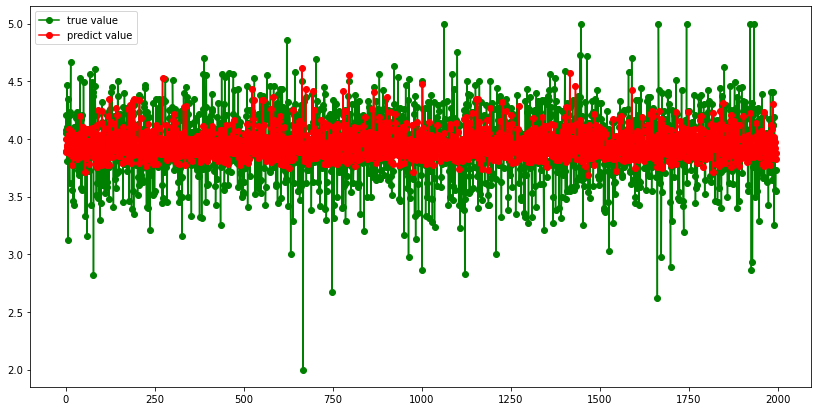

In [325]:
# define a model setting
mlpr = MLPRegressor(hidden_layer_sizes=(200), 
                    solver='adam', 
                    batch_size=512,
                    alpha=0.1, 
                    activation='relu', 
                    learning_rate_init=0.001, 
                    max_iter=1000, 
                    random_state=233, 
                    verbose=False)
# use our custom function to do one training and evaluation
evaluation, model = model_fit_predict(mlpr, x_train, y_train, x_test, y_test)

In [326]:
print('1.validation data evaluate：')
pprint(evaluation)
print('\n2.training data mse：\n', model.loss_)

1.validation data evaluate：
{'evaluation': {'MAE': 0.20912547984507168,
                'MSE': 0.07570630832997527,
                'R2_scores': 0.11858722477897454,
                'Variance_Score': 0.11866562534788483},
 'pred_time': 0.007998466491699219,
 'train_time': 9.972852230072021}

2.training data mse：
 0.03910936656582243


In [295]:
# using cross-validation method to find the best hyper-parameters
'''
score ::
dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 
'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 
'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 
'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 
'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 
'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 
'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 
'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 
'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 
'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])
'''
hls_mse = []
for hls in [10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 700, 1000]:
    mlpr = MLPRegressor(hidden_layer_sizes=(hls), 
                        solver='adam', 
                        alpha=0.0001, 
                        activation='relu', 
                        learning_rate_init=0.001, 
                        max_iter=500, 
                        random_state=233
                       )
    scores = model_selection.cross_val_score(mlpr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    hls_mse.append(abs(scores.mean()))
    print("MSE: %0.4f (+/- %0.3f) [hidden_layer_sizes:%s]" % (scores.mean(), scores.std(), hls))

MSE: -0.0821 (+/- 0.002) [hidden_layer_sizes:10]
MSE: -0.0811 (+/- 0.002) [hidden_layer_sizes:20]
MSE: -0.0792 (+/- 0.001) [hidden_layer_sizes:30]
MSE: -0.0788 (+/- 0.002) [hidden_layer_sizes:40]
MSE: -0.0790 (+/- 0.001) [hidden_layer_sizes:50]
MSE: -0.0780 (+/- 0.002) [hidden_layer_sizes:100]
MSE: -0.0782 (+/- 0.001) [hidden_layer_sizes:150]
MSE: -0.0768 (+/- 0.001) [hidden_layer_sizes:200]
MSE: -0.0770 (+/- 0.001) [hidden_layer_sizes:300]
MSE: -0.0789 (+/- 0.001) [hidden_layer_sizes:400]
MSE: -0.0775 (+/- 0.001) [hidden_layer_sizes:500]
MSE: -0.0787 (+/- 0.001) [hidden_layer_sizes:700]
MSE: -0.0816 (+/- 0.004) [hidden_layer_sizes:1000]


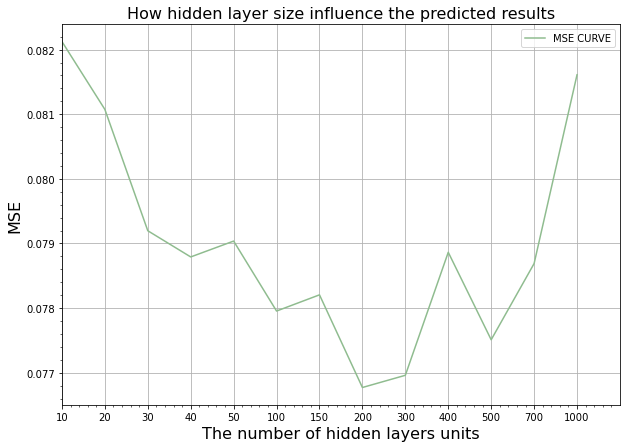

In [297]:
plot_curve(x=[10, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500, 700, 1000], y=hls_mse,
          title='How hidden layer size influence the predicted results', xlabel='The number of hidden layers units', ylabel='MSE',
          label1='MSE CURVE'
          )

In [308]:
alpha_score = []
for alpha_p in [0.00001, 0.0001, 0.001, 0.01, 0.1, 1]:
    mlpr = MLPRegressor(hidden_layer_sizes=(150), 
                        solver='adam', 
                        alpha=alpha_p, 
                        activation='relu', 
                        learning_rate_init=0.001, 
                        max_iter=200, 
                        random_state=233
                       )
    scores = model_selection.cross_val_score(mlpr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    alpha_score.append(abs(scores.mean()))
    print("MSE: %0.4f (+/- %0.3f) [alpha_values:%s]" % (scores.mean(), scores.std(), alpha_p))

MSE: -0.0779 (+/- 0.002) [alpha_values:1e-05]
MSE: -0.0779 (+/- 0.002) [alpha_values:0.0001]
MSE: -0.0780 (+/- 0.002) [alpha_values:0.001]
MSE: -0.0778 (+/- 0.002) [alpha_values:0.01]
MSE: -0.0771 (+/- 0.001) [alpha_values:0.1]


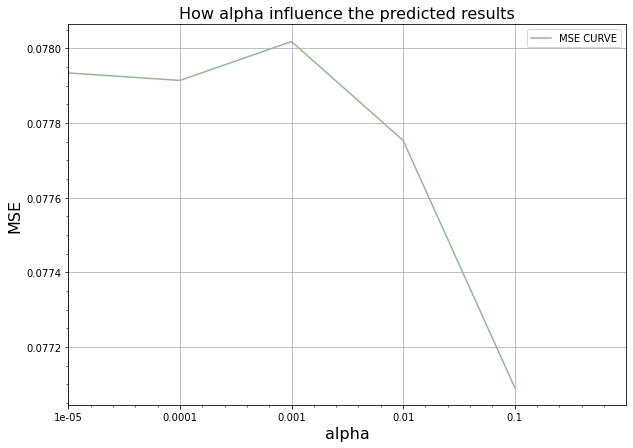

In [309]:
plot_curve(x=[0.00001, 0.0001, 0.001, 0.01, 0.1], y=alpha_score,
          title='How alpha influence the predicted results', xlabel='alpha', ylabel='MSE',
          label1='MSE CURVE'
          )

In [108]:
batch_size_score = []
for batch_size in ['auto', 256, 384, 512, 640, 768, 1024]:
    mlpr = MLPRegressor(hidden_layer_sizes=(200), 
                        solver='adam', 
                        batch_size=batch_size,
                        alpha=0.1, 
                        activation='relu', 
                        learning_rate_init=0.001, 
                        max_iter=200, 
                        random_state=233
                       )
    scores = model_selection.cross_val_score(mlpr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    batch_size_score.append(abs(scores.mean()))
    print("MSE: %0.4f (+/- %0.3f) [batch_size:%s]" % (scores.mean(), scores.std(), batch_size))

MSE: -0.0769 (+/- 0.001) [batch_size:auto]
MSE: -0.0770 (+/- 0.001) [batch_size:256]
MSE: -0.0776 (+/- 0.001) [batch_size:384]
MSE: -0.0767 (+/- 0.001) [batch_size:512]
MSE: -0.0768 (+/- 0.001) [batch_size:640]
MSE: -0.0771 (+/- 0.001) [batch_size:768]
MSE: -0.0778 (+/- 0.001) [batch_size:1024]


In [ ]:
plot_curve(x=['auto', 256, 384, 512, 640, 768, 1024], y=batch_size_score,
          title='How batch size influence the predicted results', xlabel='batch size', ylabel='MSE',
          label1='MSE CURVE'
          )

In [172]:
mlpr = MLPRegressor(hidden_layer_sizes=(200), 
                    solver='adam', 
                    batch_size=512,
                    alpha=0.1, 
                    activation='relu', 
                    learning_rate_init=0.001, 
                    max_iter=200, 
                    random_state=233
                   )
scores = model_selection.cross_val_score(mlpr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
print("MSE: %0.4f (+/- %0.3f) " % (scores.mean(), scores.std()))

MSE: -0.0770 (+/- 0.001) 


### 3.3 SVM Regression

In [223]:
from sklearn.svm import SVR

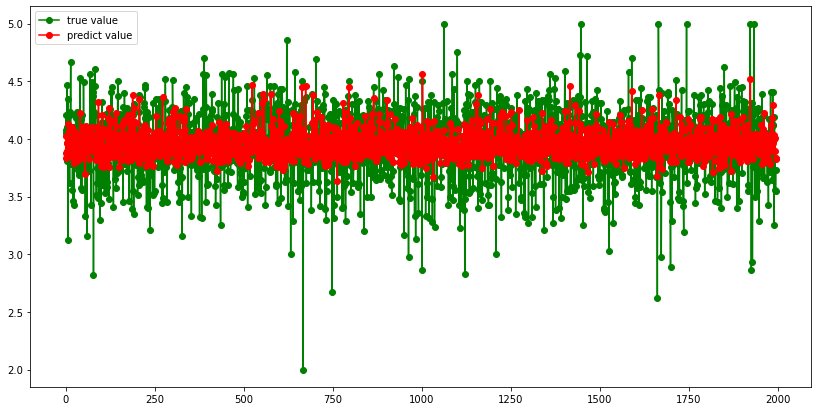

In [224]:
model = SVR(C=0.6, gamma=0.2)
evaluation, model = model_fit_predict(model, x_train, y_train, x_test, y_test)

In [225]:
evaluation

{'train_time': 4.716032266616821,
 'pred_time': 0.9703447818756104,
 'evaluation': {'Variance_Score': 0.11739441345850676,
  'MSE': 0.0758733321762871,
  'MAE': 0.20771407532519193,
  'R2_scores': 0.11664264505829736}}

In [137]:
X=[]
Y=[]
Z=[]
start = time()
for C in range(1, 10, 1):
    for gamma in range(1, 11, 1):
        model = SVR(C = C/10, gamma = gamma/10)
        mse = model_selection.cross_val_score(model, x_data, y_data, cv=3, scoring='neg_mean_squared_error')
        mse = abs(mse.mean())
        X.append(C/10)
        Y.append(gamma/10)
        Z.append(mse)
        print(X[-1], Y[-1], Z[-1])
        end = time()
        print(end - start)

0.1 0.1 0.07631645302682856
13.062998533248901
0.1 0.2 0.07579647707147147
27.137998819351196
0.1 0.3 0.07572192026568057
46.03999924659729
0.1 0.4 0.07582598977486077
61.95800042152405
0.1 0.5 0.07594590873994522
75.93099904060364
0.1 0.6 0.07600677305131744
89.76099896430969
0.1 0.7 0.07608766525273916
102.99899959564209
0.1 0.8 0.07618732932895443
116.59399890899658
0.1 0.9 0.07628794735070253
131.01333451271057
0.1 1.0 0.07639378914942806
149.14733409881592
0.2 0.1 0.07572411893655955
167.1373336315155
0.2 0.2 0.07536263226039362
185.80966901779175
0.2 0.3 0.07534711588044514
201.98065614700317
0.2 0.4 0.07548616002340057
215.24565815925598
0.2 0.5 0.07562103181352885
228.55465602874756
0.2 0.6 0.07573431836449503
242.04965567588806
0.2 0.7 0.07588125539386753
255.4086558818817
0.2 0.8 0.07599351765699637
268.7760331630707
0.2 0.9 0.0760500137577107
282.7010326385498
0.2 1.0 0.0761430843275327
296.62103509902954
0.3 0.1 0.07557391420091987
310.5030357837677
0.3 0.2 0.07522064420401

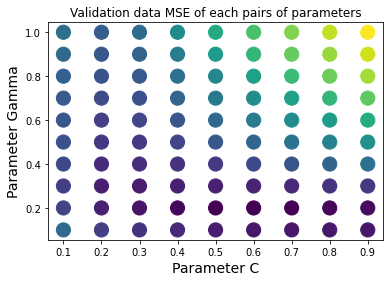

In [190]:
# higher price_range bigger *star*
plt.xlabel('Parameter C', fontsize = 14)
plt.ylabel('Parameter Gamma', fontsize = 14)
plt.title('Validation data MSE of each pairs of parameters')
plt.scatter(X, Y, s=200, c=[1000*i for i in Z], marker='o')

### 3.4 Random Forest

In [134]:
from sklearn.ensemble import RandomForestRegressor

In [270]:
# evaluate the depth
for depth in range(10, 40, 2):
    rfr = RandomForestRegressor(max_depth = depth, criterion='mse', random_state = 0)
    scores = model_selection.cross_val_score(rfr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    print("MSE: %0.4f (+/- %0.3f) [parameters:%s]" % (abs(scores.mean()), scores.std(), depth))

MSE: 0.0747 (+/- 0.001) [parameters:10]
MSE: 0.0730 (+/- 0.001) [parameters:12]
MSE: 0.0717 (+/- 0.001) [parameters:14]
MSE: 0.0707 (+/- 0.001) [parameters:16]
MSE: 0.0700 (+/- 0.000) [parameters:18]
MSE: 0.0696 (+/- 0.001) [parameters:20]
MSE: 0.0695 (+/- 0.000) [parameters:22]
MSE: 0.0694 (+/- 0.000) [parameters:24]
MSE: 0.0693 (+/- 0.000) [parameters:26]
MSE: 0.0694 (+/- 0.000) [parameters:28]
MSE: 0.0693 (+/- 0.000) [parameters:30]
MSE: 0.0694 (+/- 0.000) [parameters:32]
MSE: 0.0693 (+/- 0.001) [parameters:34]
MSE: 0.0694 (+/- 0.000) [parameters:36]
MSE: 0.0694 (+/- 0.000) [parameters:38]


In [271]:
# evaluate the max_samples
for max_samples in [i/10 for i in range(1, 10, 1)] :
    for max_features in ['auto', 'sqrt', 'log2']:
        rfr = RandomForestRegressor(max_depth = 28, criterion = 'mse', max_samples=max_samples, max_features = max_features, random_state = 0)
        scores = model_selection.cross_val_score(rfr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
        print("MSE: %0.4f (+/- %0.3f) [parameters:%s and %s]" % (abs(scores.mean()), scores.std(), max_samples, max_features))

MSE: 0.0763 (+/- 0.001) [parameters:0.1 and auto]
MSE: 0.0771 (+/- 0.001) [parameters:0.1 and sqrt]
MSE: 0.0777 (+/- 0.001) [parameters:0.1 and log2]
MSE: 0.0738 (+/- 0.001) [parameters:0.2 and auto]
MSE: 0.0740 (+/- 0.001) [parameters:0.2 and sqrt]
MSE: 0.0746 (+/- 0.001) [parameters:0.2 and log2]
MSE: 0.0722 (+/- 0.000) [parameters:0.3 and auto]
MSE: 0.0725 (+/- 0.001) [parameters:0.3 and sqrt]
MSE: 0.0730 (+/- 0.001) [parameters:0.3 and log2]
MSE: 0.0715 (+/- 0.001) [parameters:0.4 and auto]
MSE: 0.0715 (+/- 0.001) [parameters:0.4 and sqrt]
MSE: 0.0723 (+/- 0.001) [parameters:0.4 and log2]
MSE: 0.0709 (+/- 0.001) [parameters:0.5 and auto]
MSE: 0.0712 (+/- 0.001) [parameters:0.5 and sqrt]
MSE: 0.0713 (+/- 0.001) [parameters:0.5 and log2]
MSE: 0.0704 (+/- 0.001) [parameters:0.6 and auto]
MSE: 0.0703 (+/- 0.001) [parameters:0.6 and sqrt]
MSE: 0.0704 (+/- 0.001) [parameters:0.6 and log2]
MSE: 0.0697 (+/- 0.001) [parameters:0.7 and auto]
MSE: 0.0699 (+/- 0.001) [parameters:0.7 and sqrt]


In [273]:
# evaluate the estimator
# 2020/12/2
for n_estimators in range(100, 1000, 100) :
    rfr = RandomForestRegressor(n_estimators=n_estimators, max_depth = 28, criterion = 'mse', random_state = 0)
    scores = model_selection.cross_val_score(rfr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    print("MSE: %0.4f (+/- %0.3f) [parameters:%s]" % (abs(scores.mean()), scores.std(), n_estimators))

KeyboardInterrupt: 

In [228]:
# final setting after evaluation
rfr = RandomForestRegressor(n_estimators=500, max_depth = 28, criterion='mse', random_state = 233)
scores = model_selection.cross_val_score(rfr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
print("MSE: %0.4f (+/- %0.3f) " % (abs(scores.mean()), scores.std()))
# 0.0689 -100
# 0.0688 -200
# 0.0686 -300

MSE: 0.0686 (+/- 0.001) 


In [231]:
# show us the feature important while constructing.
rfre = rfr.fit(x_data, y_data)

Text(0.5, 0, 'Importance_of_features')

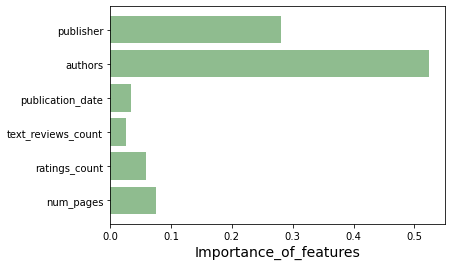

In [232]:
rf_imp = pd.Series(rfre.feature_importances_, index=x_data.columns)
rf_imp_f = pd.Series([rf_imp[0], rf_imp[1], rf_imp[2], rf_imp[3], sum(rf_imp[4:54]), sum(rf_imp[54:104]) ], index=['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date', 'authors', 'publisher'])
rf_imp_f.sort_values(ascending=False)
plt.barh(range(len(rf_imp_f.index)), rf_imp_f, tick_label=rf_imp_f.index, color='darkseagreen')
plt.xlabel('Importance_of_features', fontsize=14)

### 3.5 Ensemble Learning - Stacking

In [233]:
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [269]:
# use the best hyper-parameter above we got, to define a model
mlpr = MLPRegressor(hidden_layer_sizes=(250,), 
                    solver='adam', 
                    batch_size=512,
                    alpha=0.1, 
                    activation='relu', 
                    learning_rate_init=0.001, 
                    max_iter=1000, 
                    random_state=233, 
                    verbose=False)
svr = SVR(C=0.6, gamma=0.2)
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 28, random_state = 0)

# define the basic learners
basic_models = [
    ('MLP', mlpr),
    ('SVR', svr),
    ('RFR', rfr)
]

stackingrg = StackingRegressor(estimators=basic_models, cv=5)

for iterr, iterrlabel in zip([mlpr, rfr, svr, stackingrg] ,['MLP Regression Model',
                                  'Random Forest Model',
                                  'SVR Model',
                                  'Stacking Regression Model']):
    scores = model_selection.cross_val_score(iterr, x_data, y_data, cv = 3, scoring='neg_mean_squared_error')
    print("MSE: %0.4f (+/- %0.3f) [%s]" % (abs(scores.mean()), scores.std(), iterrlabel))

'''
MSE: 0.0768 (+/- 0.001) [MLP Regression Model]
MSE: 0.0688 (+/- 0.001) [Random Forest Model]
MSE: 0.0757 (+/- 0.001) [SVR Model]
MSE: 0.0680 (+/- 0.001) [Stacking Regression Model]
'''

MSE: 0.0768 (+/- 0.001) [MLP Regression Model]
MSE: 0.0688 (+/- 0.001) [Random Forest Model]
MSE: 0.0757 (+/- 0.001) [SVR Model]
MSE: 0.0680 (+/- 0.001) [Stacking Regression Model]


In [286]:
# use the best hyper-parameters to train the model.
mlpr = MLPRegressor(hidden_layer_sizes=(250,), 
                    solver='adam', 
                    batch_size=512,
                    alpha=0.1, 
                    activation='relu', 
                    learning_rate_init=0.001, 
                    max_iter=1000, 
                    random_state=233, 
                    verbose=False)
svr = SVR(C=0.6, gamma=0.2)
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 28, random_state = 0)

# define the basic learners
basic_models = [
    ('MLP', mlpr),
    ('SVR', svr),
    ('RFR', rfr)
]

stackingrg_show = StackingRegressor(estimators=basic_models, cv=5)
stackingrg_show.fit(x_train, y_train)

StackingRegressor(cv=5,
                  estimators=[('MLP',
                               MLPRegressor(alpha=0.1, batch_size=512,
                                            hidden_layer_sizes=(250,),
                                            max_iter=1000, random_state=233)),
                              ('SVR', SVR(C=0.6, gamma=0.2)),
                              ('RFR',
                               RandomForestRegressor(max_depth=28,
                                                     n_estimators=500,
                                                     random_state=0))])

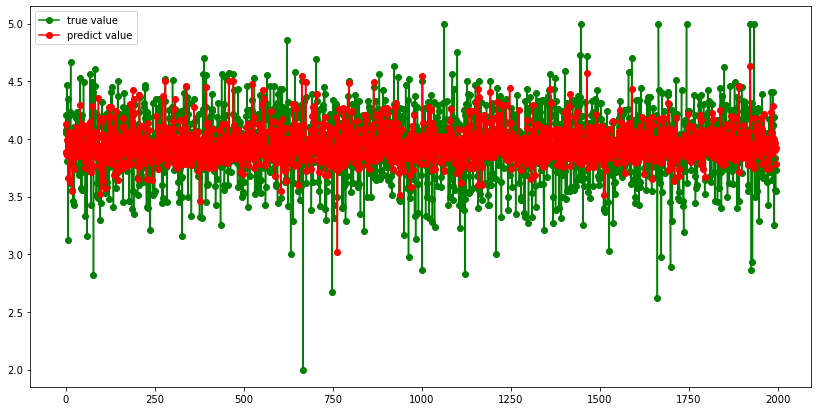

In [287]:
y_pred = stackingrg_show.predict(x_test)

fig, ax = plt.subplots(figsize=(14, 7))
plt.plot(np.arange(len(y_test)), y_test,'go-',label='true value')
plt.plot(np.arange(len(y_test)), y_pred,'ro-',label='predict value')
plt.legend()

## 4 Predict the Test_data.csv

In [246]:
# 1.we choose stacking model
# and decide to use 
# [num_pages, ratings_count, text_reviews_count, publication_date, author, publisher]
# use the trained model to predict the test data
# use the best hyper-parameter above we got, to define a model
mlpr = MLPRegressor(hidden_layer_sizes=(250,), 
                    solver='adam', 
                    batch_size=512,
                    alpha=0.1, 
                    activation='relu', 
                    learning_rate_init=0.001, 
                    max_iter=1000, 
                    random_state=233, 
                    verbose=False)
svr = SVR(C=0.6, gamma=0.2)
rfr = RandomForestRegressor(n_estimators = 500, max_depth = 28, random_state = 0)

# define the basic learners
basic_models = [
    ('MLP', mlpr),
    ('SVR', svr),
    ('RFR', rfr)
]

stackingrg = StackingRegressor(estimators=basic_models, cv=5)

stackingrg.fit(x_data, y_data)

StackingRegressor(cv=5,
                  estimators=[('MLP',
                               MLPRegressor(alpha=0.1, batch_size=512,
                                            hidden_layer_sizes=(250,),
                                            max_iter=1000, random_state=233)),
                              ('SVR', SVR(C=0.6, gamma=0.2)),
                              ('RFR',
                               RandomForestRegressor(max_depth=28,
                                                     n_estimators=500,
                                                     random_state=0))])

In [247]:
# 2.Repeat the data processing job as before
new_data_verification = data_verification.drop(columns=['average_rating', 'title', 'publisher', 'authors', 'isbn13', 'isbn', 'bookID', 'language_code'])
authors_vec_verification = pd.DataFrame(authors_data_verification, columns=[('authors_vec_'+str(i)) for i in range(len(authors_data[0]))])
publisher_vec_verification = pd.DataFrame(publisher_data_verification, columns=[('publisher_vec_'+str(i)) for i in range(len(publisher_data[0]))])
new_data_verification = pd.concat([new_data_verification, authors_vec_verification, publisher_vec_verification], axis=1)

# 
g = StandardScaler().fit_transform(new_data_verification)
standarall = pd.DataFrame(g , columns=new_data_verification.columns)

# 
feature_selection = ['num_pages', 'ratings_count', 'text_reviews_count', 'publication_date'] 
data_final_verification = new_data_verification
data_final_verification[feature_selection] = standarall[feature_selection]

In [248]:
data_final_verification.head(5)

,num_pages,ratings_count,text_reviews_count,publication_date,authors_vec_0,authors_vec_1,authors_vec_2,authors_vec_3,authors_vec_4,authors_vec_5,...,publisher_vec_40,publisher_vec_41,publisher_vec_42,publisher_vec_43,publisher_vec_44,publisher_vec_45,publisher_vec_46,publisher_vec_47,publisher_vec_48,publisher_vec_49
0,2.193875,-0.271602,-0.285705,0.697569,0.000060,-0.004879,-0.005706,-0.002189,0.008513,0.000542,...,-0.006152,-0.026364,0.049430,0.031098,-0.007868,-0.080376,0.001465,-0.012117,0.000101,-0.006591
1,-0.340226,-0.263920,-0.275267,0.554011,0.007984,0.007535,0.000647,-0.006646,-0.006830,0.005706,...,0.003509,-0.003173,0.032070,0.006002,-0.011856,-0.034708,0.003176,-0.009329,-0.000640,0.000223
2,0.119913,-0.271456,-0.285053,0.331605,0.007618,-0.005603,0.003945,-0.000203,0.008372,0.007486,...,-0.000292,-0.015436,0.009728,0.000485,-0.006457,-0.015835,0.015111,-0.008857,0.013190,0.005592
3,-0.106822,0.366585,0.977308,0.223706,-0.000183,0.002527,0.016315,-0.001692,-0.018776,0.015949,...,-0.149873,-0.173379,0.121245,0.201757,-0.121548,0.038258,-0.187428,-0.163179,0.015868,0.091094
4,0.009880,-0.214279,-0.269396,0.351659,0.002256,0.003925,0.008934,0.003259,0.000197,0.011364,...,0.004396,-0.063093,0.141478,0.091602,-0.012463,-0.193456,0.026775,-0.043510,0.011326,0.004403


In [250]:
y_pred = stackingrg.predict(data_final_verification)

In [265]:
project_pred = pd.concat([data_verification_raw.iloc[:, :3], pd.DataFrame(data = y_pred, columns=['average_rating']), data_verification_raw.iloc[:, 4:]], axis=1)

In [266]:
project_pred

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,28898,Fundamentals of Heat and Mass Transfer [with I...,Frank P. Incropera/David P. DeWitt,4.370298,0470055545,9780470055540,en-US,997,6,0,10/30/2006,Wiley
1,39358,Stud Rites (A Dog Lover's Mystery #9),Susan Conant,3.825976,0425201597,9780425201596,eng,237,322,16,3/1/2005,Berkley Prime Crime Books
2,32695,El talismán,Stephen King/Peter Straub/Pilar Giralt Gorina,3.898597,8408042432,9788408042433,spa,375,12,1,7/1/2003,Planeta Publishing
3,15096,Five Quarters of the Orange,Joanne Harris,3.696815,0060958022,9780060958022,eng,307,26258,1936,6/4/2002,Harper Perennial
4,15428,Up in a Heaval (Xanth #26),Piers Anthony,3.778127,0812574990,9780812574999,eng,342,2364,25,10/19/2003,Tor Fantasy
...,...,...,...,...,...,...,...,...,...,...,...,...
995,30411,Texas! Trilogy,Sandra Brown,4.075018,0385424701,9780385424707,eng,600,949,39,4/1/1992,Doubleday Books
996,19634,Who Will Run the Frog Hospital?,Lorrie Moore,3.765559,1400033829,9781400033829,eng,160,6419,628,4/13/2004,Vintage
997,44236,The Civil War Vol. 1: Fort Sumter to Perryville,Shelby Foote,4.358323,0394746236,9780394746234,eng,856,9760,346,11/12/1986,Vintage
998,24827,Ship of Fools,Richard Paul Russo,3.588432,0441008933,9780441008933,eng,370,2192,206,12/31/2001,Ace


In [268]:
# 3.output the test data in csv format
# please mention :: the predicted average_rating columns is the tail columns.
# columns = [col1, col2, col3, ...., 'average_rating']
project_pred.to_csv('Test_data_predicted.csv', index=False,)

In [ ]:
'''
With the help of embedding algorithm (here we use word2vec), we can extract clearer information for our model training.
After several training iterations, model selections, and re-processing the training data (such as dropping some irrelevant feature and unimportant feature, adjusting the splitting etc. strategy), 
We finally find out the best hyper-parameter for each models and the stacking model which has the best performance. 
As you can see, with the help of cross-validation (3-fold) we can get the best MSE in 0.680 for the validation data. 

As an ensemble learning, stacking can easily improve the performance as well as reducing the variance by merging the predicted results from learning basic learners` output. 
Here the basic learners we used are MLPregressor, SVMregressor and Randomforestregressor.

Last but not least, To predicting our project Test_data.csv, we should process our Test_data again in the same way, 
and use the trained stacking model (stacking for all train_data.csv) to predict it, and out put in csv format.
''' 